## 使用mxnet 和gluon 实现

In [1]:
from mxnet import ndarray as nd
from mxnet import autograd
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [2]:
num_inputs = 2
num = 1000

true_w = [2, -3.4]
true_b = 4.2

X = nd.random_normal(shape=(num, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(shape=y.shape)

### 读取数据
生成第一个特征值 (X[:, 0]) 和目标值 Y 的散点图，更直观地观察两者间的关系。

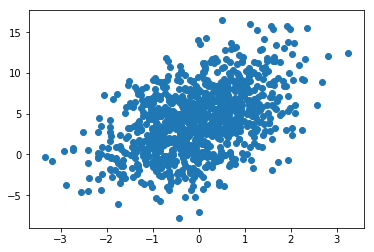

In [3]:
plt.scatter(X[:, 0].asnumpy(),y.asnumpy())
plt.show()

训练神经网络的时候，我们需要不断读取数据块。这里我们定义一个函数它每次返回batch_size个随机的样本和对应的目标。这里可以通过python的yield来构造一个迭代器

In [4]:
import random
batch_size = 10
def data_iter():
    # 产生一个随机索引
    idx = list(range(num))
    random.shuffle(idx)
    for i in range(0, num, batch_size):
        j = nd.array(idx[i:min(i+batch_size,num)])
        yield nd.take(X, j), nd.take(y, j)

代码读取第一个随机数据块

In [5]:
for data, label in data_iter():
    print(data, label)
    break

(
[[ 0.80086499  0.64161378]
 [-1.80192304 -0.10250449]
 [-1.38438416  0.18498537]
 [-1.10425019 -1.43397725]
 [ 0.54155749 -0.20159695]
 [ 1.61745751 -0.42109194]
 [ 0.12135358  0.01578125]
 [ 0.87809837 -1.07333779]
 [ 1.09420443 -1.16012454]
 [-0.47545174  1.92679763]]
<NDArray 10x2 @cpu(0)>, 
[  3.60913038   0.93919462   0.81189185   6.85887575   5.97680855
   8.87133217   4.38811398   9.61106586  10.32493496  -3.30009222]
<NDArray 10 @cpu(0)>)


## 初始化模型参数

In [6]:
# 初始化参数
w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros((1,))
params = [w, b]


for param in params:
    param.attach_grad()
    
# 定义线性模型
def net(X):
    return nd.dot(X, w) + b

# 定义损失函数
def square_loss(yhat, y):
    # 注意这里我们把y变形成yhat的形状来避免矩阵形状的自动转换
    return (yhat - y.reshape(yhat.shape)) ** 2

# 优化参数
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [7]:
# 模型函数
def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
# 绘制损失随训练次数降低的折线图，以及预测值和真实值的散点图
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()
    plt.show()

Epoch 0, batch 99. Moving avg of loss: 6.89381875509. Average loss: 9.126331


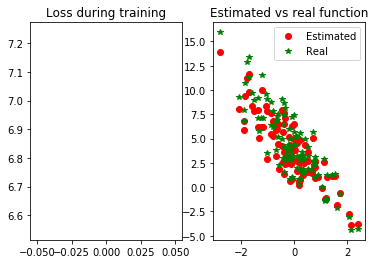

Epoch 1, batch 199. Moving avg of loss: 1.91797735015. Average loss: 0.136632


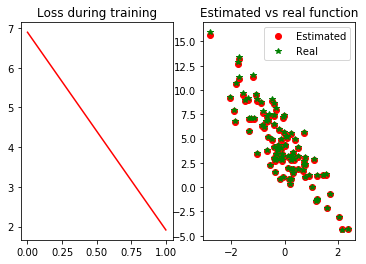

Epoch 2, batch 299. Moving avg of loss: 0.639934797751. Average loss: 0.002395


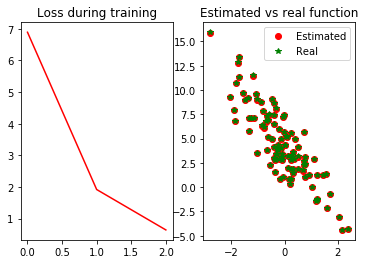

Epoch 3, batch 399. Moving avg of loss: 0.226826680471. Average loss: 0.000134


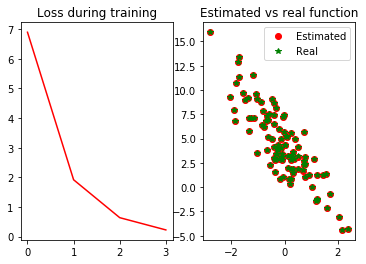

Epoch 4, batch 499. Moving avg of loss: 0.0821235587878. Average loss: 0.000091


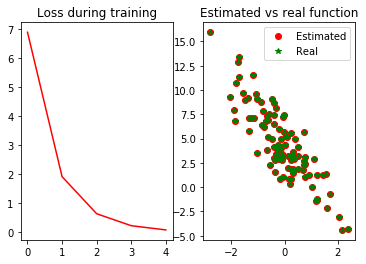

In [8]:
epochs = 5
learning_rate = .001
niter = 0
losses = []
moving_loss = 0
smoothing_constant = .01

# 训练
for e in range(epochs):
    total_loss = 0

    for data, label in data_iter():
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += nd.sum(loss).asscalar()

        # 记录每读取一个数据点后，损失的移动平均值的变化；
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)

        if (niter + 1) % 100 == 0:
            losses.append(est_loss)
            print("Epoch %s, batch %s. Moving avg of loss: %s. Average loss: %f" % (e, niter, est_loss, total_loss/num))
            plot(losses, X)
  